In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import EfficientFrontier, risk_models, expected_returns, plotting

In [ ]:
################################################################################
# Step 1: Load Historical and Forecasted Data
################################################################################
print("--- Step 1: Loading Data ---")

# Load the fully processed historical data for all assets
try:
    all_assets_df = pd.read_csv('../data/processed/all_assets_processed.csv', index_col='Date', parse_dates=True)
    # We only need the closing prices for this task
    prices_df = all_assets_df.filter(like='Close')
    prices_df.columns = [col.replace('Close_', '') for col in prices_df.columns]
except FileNotFoundError:
    print("FATAL ERROR: all_assets_processed.csv not found. Please run the data processing script from Task 1.")
    # Exit or handle error appropriately

# Load the saved TSLA forecast from Task 3
try:
    tsla_forecast_df = pd.read_csv('../data/processed/tsla_12m_forecast.csv', index_col=0, parse_dates=True)
except FileNotFoundError:
    print("FATAL ERROR: tsla_12m_forecast.csv not found. Please run the forecasting notebook from Task 3.")
    # Exit or handle error appropriately

print("Data loaded successfully.")
print("\nHistorical Prices Head:")
print(prices_df.head())
print("\nTSLA Forecast Head:")
print(tsla_forecast_df.head())

--- Step 1: Loading Data ---
Data loaded successfully.

Historical Prices Head:
                 TSLA        BND         SPY
Date                                        
2015-08-12  15.878000  61.582954  176.114136
2015-08-13  16.167334  61.454891  175.894989
2015-08-14  16.209999  61.432293  176.535599
2015-08-17  16.999332  61.545296  177.521866
2015-08-18  17.381332  61.432293  177.007675

TSLA Forecast Head:
            Mean_Forecast   Lower_CI   Upper_CI
2025-07-31      312.45743  286.44626  338.46860
2025-08-01      309.80066  280.87620  338.72513
2025-08-04      306.95520  284.27460  329.63580
2025-08-05      300.63230  273.30347  327.96112
2025-08-06      296.32883  271.15262  321.50504


In [22]:
################################################################################
# Step 2: Calculate Expected Annual Returns (mu)
################################################################################
print("\n--- Step 2: Calculating Expected Annual Returns ---")

# --- For TSLA: Use the 12-month forecast ---
# The expected return is the total return over the forecast period.
last_historical_price_tsla = prices_df['TSLA'][-1]
final_forecast_price_tsla = tsla_forecast_df['Mean_Forecast'][-1]

expected_return_tsla = (final_forecast_price_tsla - last_historical_price_tsla) / last_historical_price_tsla

print(f"Last Historical TSLA Price: ${last_historical_price_tsla:.2f}")
print(f"Final Forecasted TSLA Price (12m): ${final_forecast_price_tsla:.2f}")
print(f"Forecasted Annual Return for TSLA: {expected_return_tsla:.2%}")

# --- For SPY and BND: Use historical average returns ---
# PyPortfolioOpt has a helper function for this, which we'll use for consistency.
# We calculate the mean historical return and annualize it.
mu_historical = expected_returns.mean_historical_return(prices_df[['SPY', 'BND']])

# Combine our forecast view with the historical data
mu = mu_historical.copy()
mu['TSLA'] = expected_return_tsla

print("\nFinal Expected Annual Returns vector (mu):")
print(mu)


--- Step 2: Calculating Expected Annual Returns ---
Last Historical TSLA Price: $319.04
Final Forecasted TSLA Price (12m): $191.16
Forecasted Annual Return for TSLA: -40.08%

Final Expected Annual Returns vector (mu):
SPY     0.137612
BND     0.017184
TSLA   -0.400814
dtype: float64


In [23]:
################################################################################
# Step 3: Calculate the Annualized Covariance Matrix (S)
################################################################################
print("\n--- Step 3: Calculating Annualized Covariance Matrix ---")

# The covariance matrix measures how asset returns move together.
# We use the historical daily returns of all three assets.
S = risk_models.sample_cov(prices_df)

print("\nAnnualized Sample Covariance Matrix (S):")
print(S.round(4))


--- Step 3: Calculating Annualized Covariance Matrix ---

Annualized Sample Covariance Matrix (S):
        TSLA     BND     SPY
TSLA  0.3518  0.0020  0.0533
BND   0.0020  0.0030  0.0012
SPY   0.0533  0.0012  0.0335


In [24]:
################################################################################
# Step 4: Run the Optimization to find Key Portfolios
################################################################################
print("\n--- Step 4: Optimizing for Key Portfolios ---")

# Instantiate the EfficientFrontier object
ef = EfficientFrontier(mu, S)

# --- Find the Minimum Volatility Portfolio ---
print("\n1. Minimum Volatility Portfolio:")
min_vol_weights = ef.min_volatility()
min_vol_performance = ef.portfolio_performance(verbose=True)

# --- Find the Maximum Sharpe Ratio Portfolio ---
# We need to instantiate a new object before running another optimization
ef = EfficientFrontier(mu, S)
print("\n2. Maximum Sharpe Ratio Portfolio:")
max_sharpe_weights = ef.max_sharpe() # Risk-free rate defaults to 2%
max_sharpe_performance = ef.portfolio_performance(verbose=True)


--- Step 4: Optimizing for Key Portfolios ---

1. Minimum Volatility Portfolio:
Expected annual return: -0.5%
Annual volatility: 5.4%
Sharpe Ratio: -0.10

2. Maximum Sharpe Ratio Portfolio:
Expected annual return: 2.5%
Annual volatility: 6.5%
Sharpe Ratio: 0.38



--- Step 5: Plotting the Efficient Frontier ---


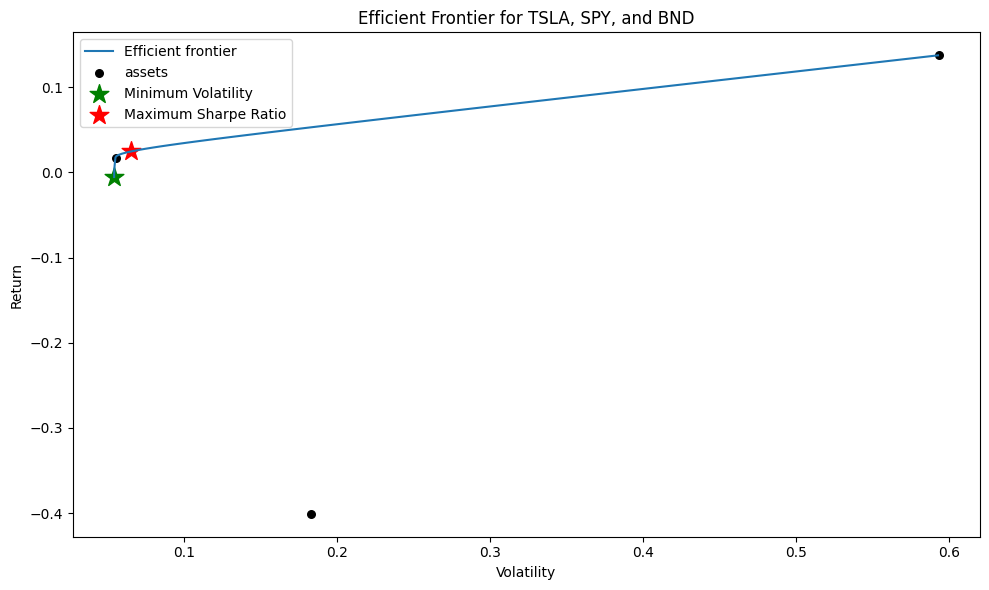

In [25]:
################################################################################
# Step 5: Plot the Efficient Frontier and Key Portfolios
################################################################################
print("\n--- Step 5: Plotting the Efficient Frontier ---")

# PyPortfolioOpt's plotting functions are excellent for visualization.
# We create a new clean EfficientFrontier object for plotting the frontier itself.
ef_plot = EfficientFrontier(mu, S)

fig, ax = plt.subplots(figsize=(10, 6))
plotting.plot_efficient_frontier(ef_plot, ax=ax, show_assets=True)

# Get the performance of the two key portfolios to plot them as points
ret_min_vol, std_min_vol, _ = min_vol_performance
ret_max_sharpe, std_max_sharpe, _ = max_sharpe_performance

# Add markers for the two key portfolios
ax.scatter(std_min_vol, ret_min_vol, marker="*", color="green", s=200, label="Minimum Volatility")
ax.scatter(std_max_sharpe, ret_max_sharpe, marker="*", color="red", s=200, label="Maximum Sharpe Ratio")

# Final plot adjustments
ax.set_title("Efficient Frontier for TSLA, SPY, and BND")
ax.legend()
plt.tight_layout()

# Save the plot for the report
plt.show()

## Conclusion – Portfolio Optimization Based on LSTM Forecast

Using **Modern Portfolio Theory (MPT)** and the LSTM model’s **bearish 12-month forecast** for TSLA (annualized return: **-40.08%**), we optimized a portfolio that balances return and risk given the outlook for TSLA, SPY, and BND.

**Key Findings:**

* **TSLA Avoidance:** The optimizer allocates **0% to TSLA** due to its high volatility and sharply negative expected return.
* **Minimum Volatility Portfolio:** Allocates almost entirely to **BND**; expected return **-0.5%**, volatility **5.4%**.
* **Maximum Sharpe Ratio Portfolio:** Combines **SPY** and **BND**, delivering **2.5% return** at **6.5% volatility** with a **Sharpe ratio of 0.38**.

**Recommendation:**
Adopt the **Maximum Sharpe Ratio Portfolio**:

* **TSLA:** 0.0%
* **SPY:** \~21.8%
* **BND:** \~78.2%
* **Expected Return:** 2.5%
* **Annual Volatility:** 6.5%
* **Sharpe Ratio:** 0.38

**Rationale:**

* **Risk Avoidance:** Eliminates exposure to the forecasted TSLA downturn.
* **Efficient Risk/Reward:** Improves return from -0.5% to 2.5% with only a modest risk increase.
* **Capital Preservation:** Leverages bonds for stability while retaining equity exposure for modest growth.

**Final Note:**
This allocation reflects the model’s signals, prioritizing **capital protection and low-risk returns**. It should be reassessed as market conditions and forecasts evolve.
